In [1]:
import tensorflow as tf
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from IPython.display import clear_output

In [2]:
path = Path.cwd() / 'datasets' / 'BankChurners.csv'
df = pd.read_csv(path)
df = df.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'])
df['Attrition_Flag'] = df['Attrition_Flag'].astype(str)
df['Attrition_Flag'] = df['Attrition_Flag'].str.replace('Existing Customer', '0')
df['Attrition_Flag'] = df['Attrition_Flag'].str.replace('Attrited Customer', '1')
df['Attrition_Flag'] = df['Attrition_Flag'].astype(int)
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,0,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [3]:
df.dtypes

CLIENTNUM                     int64
Attrition_Flag                int32
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

In [4]:
#nan check
nans = df.columns[df.isna().any()].tolist()
print(nans)

[]


In [5]:
df_num = df.select_dtypes(exclude=['object'])
df_string = df.select_dtypes(include=['object'])

In [6]:
df_onehot = pd.get_dummies(df_string)
cdf = pd.concat([df_num, df_onehot], axis=1)

In [7]:
rand = np.random.rand(len(df)) < 0.8
xtrain = cdf[rand]
xtest = cdf[~rand]
ytrain = xtrain.pop('Attrition_Flag')
ytest = xtest.pop('Attrition_Flag')

In [8]:
feature_columns = []
columns = list(cdf.columns)
for feature_name in columns:
    if feature_name != 'Attrition_Flag':
        feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))
# print("")
# print(feature_columns)

NUM_EXAMPLES = len(ytrain)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X),y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        dataset = dataset.repeat(n_epochs)
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

train_input_fn = make_input_fn(xtrain, ytrain)
eval_input_fn = make_input_fn(xtest, ytest, shuffle=False, n_epochs=1)

In [9]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

linear_est.train(train_input_fn, max_steps=100)

result = linear_est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                8.402778e-01
accuracy_baseline       8.402778e-01
auc                     5.000000e-01
auc_precision_recall    1.597222e-01
average_loss            3.039114e+06
label/mean              1.597222e-01
loss                    3.039114e+06
precision               0.000000e+00
prediction/mean         0.000000e+00
recall                  0.000000e+00
global_step             1.000000e+02
dtype: float64


In [10]:
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(
    feature_columns,
    n_batches_per_layer=n_batches,
    n_trees=50,
    max_depth=3,
    center_bias=True,
#     train_in_memory=True
)

est.train(train_input_fn, max_steps=100)

result = est.evaluate(eval_input_fn)

clear_output()
pd.Series(result).to_frame()

,0
accuracy,0.960317
accuracy_baseline,0.840278
auc,0.989606
auc_precision_recall,0.949448
average_loss,0.122978
label/mean,0.159722
loss,0.122978
precision,0.935252
prediction/mean,0.159895
recall,0.807453


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\josephdavis\AppData\Local\Temp\tmpu9mjnl_n\model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


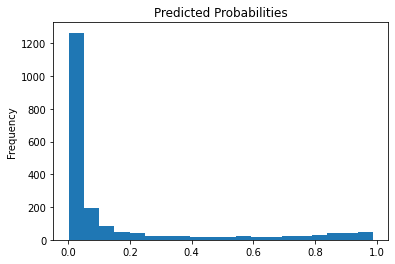

In [11]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
probs.plot(kind='hist', bins=20, title='Predicted Probabilities')
plt.show()

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

In [13]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\josephdavis\\AppData\\Local\\Temp\\tmpu9mjnl_n', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:

In [21]:
labels = ytest.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
test = pd.DataFrame(pred_dicts[0:10])
print(test)
# df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
# df_dfc.describe().T

         logits        logistic              probabilities class_ids classes  \
0  [-3.3137593]    [0.03510217]    [0.9648979, 0.03510217]       [0]  [b'0']   
1  [-2.0877314]    [0.11029499]  [0.88970506, 0.110295005]       [0]  [b'0']   
2  [-2.1657178]    [0.10287156]   [0.89712846, 0.10287156]       [0]  [b'0']   
3  [-4.4535694]   [0.011503095]   [0.9884969, 0.011503095]       [0]  [b'0']   
4  [-4.6313133]   [0.009647966]   [0.9903521, 0.009647966]       [0]  [b'0']   
5   [-4.985868]  [0.0067874594]    [0.9932126, 0.00678746]       [0]  [b'0']   
6   [-4.364051]   [0.012566794]  [0.98743314, 0.012566794]       [0]  [b'0']   
7  [-2.6448941]    [0.06630441]    [0.9336956, 0.06630441]       [0]  [b'0']   
8   [2.1933672]     [0.8996523]     [0.1003477, 0.8996523]       [1]  [b'1']   
9  [-3.2492952]    [0.03735222]   [0.9626478, 0.037352223]       [0]  [b'0']   

  all_class_ids   all_classes      bias  \
0        [0, 1]  [b'0', b'1']  0.160893   
1        [0, 1]  [b'0', b'1']  0.

In [15]:
bias = pred_dicts[0]["bias"]
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values, probs.values)

In [22]:
# Boilerplate code for plotting :)
# def _get_color(value):
#     """To make positive DFCs plot green, negative DFCs plot red."""
#     green, red = sns.color_palette()[2:4]
#     if value >= 0: return green
#     return red

def _add_feature_values(feature_values, ax):
    """Display feature's values on left of plot."""
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
    fontproperties=font, size=12)

def plot_example(example):
  TOP_N = 8 # View top 8 features.
  sorted_ix = example.abs().sort_values()[-TOP_N:].index  # Sort by magnitude.
  example = example[sorted_ix]
#   colors = example.map(_get_color).tolist()
  ax = example.to_frame().plot(kind='barh',
                          color=['red','green'],
                          legend=None,
                          alpha=0.75,
                          figsize=(10,6))
  ax.grid(False, axis='y')
  ax.set_yticklabels(ax.get_yticklabels(), size=14)

  # Add feature values.
  _add_feature_values(xtest.iloc[ID][sorted_ix], ax)
  return ax

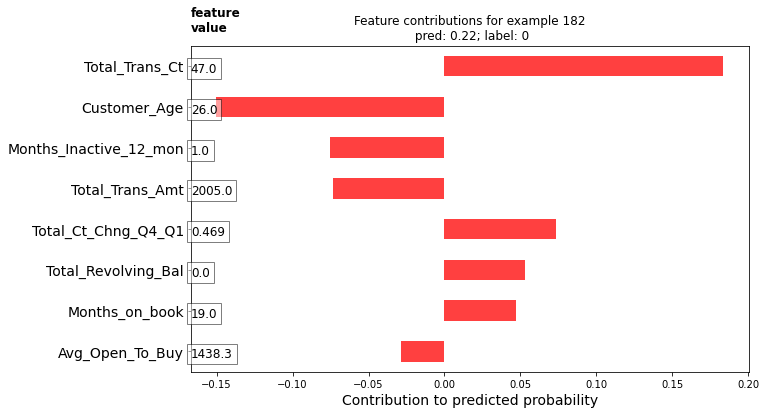

In [23]:
# Plot results.
ID = 182
example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
TOP_N = 8  # View top 8 features.
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()

In [24]:
# Boilerplate plotting code.
def dist_violin_plot(df_dfc, ID):
  # Initialize plot.
  fig, ax = plt.subplots(1, 1, figsize=(10, 6))

  # Create example dataframe.
  TOP_N = 8  # View top 8 features.
  example = df_dfc.iloc[ID]
  ix = example.abs().sort_values()[-TOP_N:].index
  example = example[ix]
  example_df = example.to_frame(name='dfc')

  # Add contributions of entire distribution.
  parts=ax.violinplot([df_dfc[w] for w in ix],
                 vert=False,
                 showextrema=False,
                 widths=0.7,
                 positions=np.arange(len(ix)))
  face_color = sns_colors[0]
  alpha = 0.15
  for pc in parts['bodies']:
      pc.set_facecolor(face_color)
      pc.set_alpha(alpha)

  # Add feature values.
  _add_feature_values(xtest.iloc[ID][sorted_ix], ax)

  # Add local contributions.
  ax.scatter(example,
              np.arange(example.shape[0]),
              color=sns.color_palette()[2],
              s=100,
              marker="s",
              label='contributions for example')

  # Legend
  # Proxy plot, to show violinplot dist on legend.
  ax.plot([0,0], [1,1], label='eval set contributions\ndistributions',
          color=face_color, alpha=alpha, linewidth=10)
  legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large',
                     frameon=True)
  legend.get_frame().set_facecolor('white')

  # Format plot.
  ax.set_yticks(np.arange(example.shape[0]))
  ax.set_yticklabels(example.index)
  ax.grid(False, axis='y')
  ax.set_xlabel('Contribution to predicted probability', size=14)

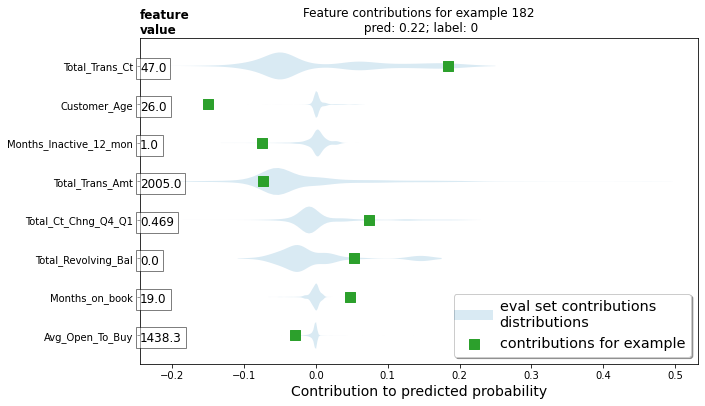

In [25]:
dist_violin_plot(df_dfc, ID)
plt.title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
plt.show()

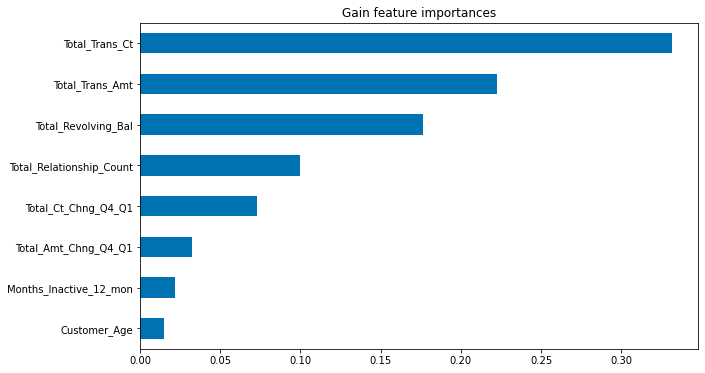

In [26]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
N = 8
ax = (df_imp.iloc[0:N][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

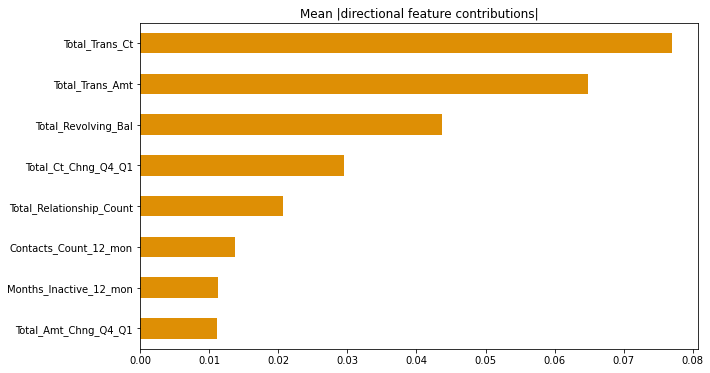

In [27]:
# Plot.
dfc_mean = df_dfc.abs().mean()
N = 8
sorted_ix = dfc_mean.abs().sort_values()[-N:].index  # Average and sort by absolute.
ax = dfc_mean[sorted_ix].plot(kind='barh',
                       color=sns_colors[1],
                       title='Mean |directional feature contributions|',
                       figsize=(10, 6))
ax.grid(False, axis='y')

c:\users\josephdavis\desktop\tensorflow notebooks\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


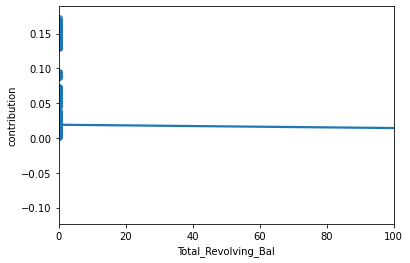

In [32]:
FEATURE = 'Total_Revolving_Bal'
feature = pd.Series(df_dfc[FEATURE].values, index=xtest[FEATURE].values).sort_index()
ax = sns.regplot(feature.index.values, feature.values, lowess=True)
ax.set_ylabel('contribution')
ax.set_xlabel(FEATURE)
ax.set_xlim(0, 100)
plt.show()